In [1]:
import pandas as pd

# Load merged csv
df = pd.read_csv('D:/Users/balans/Desktop/PBI/Customer Support Ticket Prioritization/data/merged_tickets.csv')
df.head()

,ticket_id,subject,description,date_received,department_id,priority_label,name
0,1001,Agent every development say.,Opportunity all behavior discussion. Ago curre...,2025-07-22,1,Low,IT Support
1,1002,Behavior benefit suggest page.,Movie win her need stop peace technology.,2025-07-22,3,Low,Technical
2,1003,Relate animal direction eye bag.,Herself law street class. Decide environment v...,2025-07-22,2,High,Billing
3,1004,Left establish understand read.,Successful simply director allow firm environm...,2025-07-22,5,Low,Account Management
4,1005,Central cause seat much section investment on.,Young catch management sense technology. Physi...,2025-07-22,4,Low,General


In [2]:
# Combine Subject + Description
df['text'] = df['subject'] + ' ' + df['description']

In [3]:
# pip install scikit-learn

In [4]:
# Encode priority label
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['priority_encoded'] = le.fit_transform(df['priority_label'])
print(le.classes_)      # To see label order

['Critical' 'High' 'Low' 'Medium']


In [5]:
# Train Test Split
from sklearn.model_selection import train_test_split

X = df['text']
y = df['priority_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [7]:
# Train a classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(class_weight='balanced')
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

df['priority_label'].value_counts()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification_Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.275
Classification_Report:
               precision    recall  f1-score   support

    Critical       0.00      0.00      0.00         2
        High       0.00      0.00      0.00        10
         Low       0.21      0.25      0.23        12
      Medium       0.42      0.50      0.46        16

    accuracy                           0.28        40
   macro avg       0.16      0.19      0.17        40
weighted avg       0.23      0.28      0.25        40



In [8]:
import joblib

# Save the model and vectorizer
joblib.dump(model, 'priority_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [9]:
# Alternate Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Common pipeline setup for text classification
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(class_weight='balanced',random_state=42))
])

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(class_weight='balanced',random_state=42))
])

# Train basic models
rf_pipeline.fit(X_train, y_train)
svm_pipeline.fit(X_train, y_train)

# Evaluate validation set
print("Random Forest Accusracy: ", rf_pipeline.score(X_test, y_test))
print("SVM Accuracy: ", svm_pipeline.score(X_test, y_test))

Random Forest Accusracy:  0.375
SVM Accuracy:  0.425


In [10]:
from sklearn.model_selection import GridSearchCV

# Tune only Random Forest
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__max_depth': [None, 10, ...], 'clf__min_samples_split': [2, 5], 'clf__n_estimators': [100, 200]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [11]:
# Select the best model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

# Best trained pipeline
final_model = grid_search.best_estimator_

# Validate on test set
val_accuracy = final_model.score(X_test, y_test)
print("Validation Accuracy (Best Model): ", val_accuracy)

Best parameters: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Best cross-validation F1 score: 0.29001428349369773
Validation Accuracy (Best Model):  0.325


In [12]:
import joblib

# Save the best model
joblib.dump(final_model, 'D:/Users/balans/Desktop/PBI/Customer Support Ticket Prioritization/models/final_model.pkl')

joblib.dump(X_test, 'D:/Users/balans/Desktop/PBI/Customer Support Ticket Prioritization/models/X_test.pkl')
joblib.dump(y_test, 'D:/Users/balans/Desktop/PBI/Customer Support Ticket Prioritization/models/y_test.pkl')

['D:/Users/balans/Desktop/PBI/Customer Support Ticket Prioritization/models/y_test.pkl']

priority_encoded
2    60
3    54
1    31
0    15
Name: count, dtype: int64


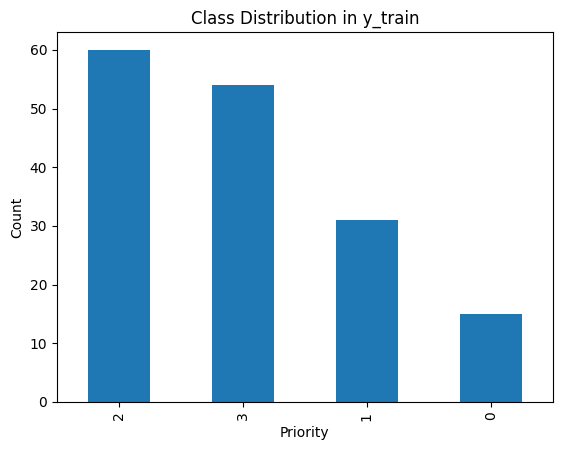

In [13]:
import matplotlib.pyplot as plt

# Check distribution
label_counts = y_train.value_counts()
print(label_counts)

# Optional: plot it
label_counts.plot(kind='bar', title='Class Distribution in y_train')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.show()
